# Creating Shakespeare Sonnets Using LSTM

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import tensorflow as tf
import numpy as np 
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2019-09-23 08:29:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.206.176, 2a00:1450:4017:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.206.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.05s   

2019-09-23 08:29:59 (1.80 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



## Tokenizing and data preprocessing

In [4]:
data = open('/tmp/sonnets.txt').read()
corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Defining the LSTM model

In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

## Training the model

In [6]:
with tf.device('/device:GPU:0'):
    history = model.fit(predictors, label, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
15462/15462 [==============================] - 40s 3ms/sample - loss: 6.9114 - acc: 0.0208
Epoch 2/100
15462/15462 [==============================] - 50s 3ms/sample - loss: 6.5011 - acc: 0.0238
Epoch 3/100
15462/15462 [==============================] - 59s 4ms/sample - loss: 6.3918 - acc: 0.0259
Epoch 4/100
15462/15462 [==============================] - 60s 4ms/sample - loss: 6.2640 - acc: 0.0307
Epoch 5/100
15462/15462 [==============================] - 61s 4ms/sample - loss: 6.1691 - acc: 0.0350
Epoch 6/100
15462/15462 [==============================] - 75s 5ms/sample - loss: 6.0770 - acc: 0.0387
Epoch 7/100
15462/15462 [==============================] - 65s 4ms/sample - loss: 5.9866 - acc: 0.0407
Epoch 8/100
15462/15462 [==============================] - 67s 4ms/sample - loss: 5.8864 - acc: 0.0434
Epoch 9/100
15462/15462 [==============================] - 61s 4ms/sample - loss: 

15462/15462 [==============================] - 37s 2ms/sample - loss: 1.5157 - acc: 0.7401
Epoch 77/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4949 - acc: 0.7399
Epoch 78/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.4934 - acc: 0.7412
Epoch 79/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4507 - acc: 0.7478
Epoch 80/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4448 - acc: 0.7499
Epoch 81/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4226 - acc: 0.7593
Epoch 82/100
15462/15462 [==============================] - 39s 3ms/sample - loss: 1.4089 - acc: 0.7606
Epoch 83/100
15462/15462 [==============================] - 40s 3ms/sample - loss: 1.3890 - acc: 0.7594
Epoch 84/100
15462/15462 [==============================] - 39s 3ms/sample - loss: 1.3704 - acc: 0.7664
Epoch 85/100
15462/15462 [==============================] - 39s 2ms/sample - 

## Visualizing the results

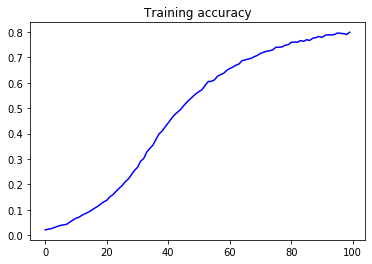

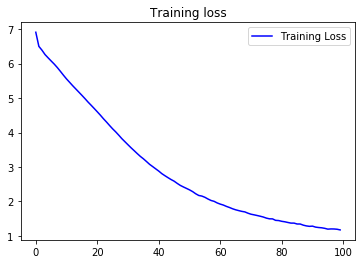

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Testing the model

In [9]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope what this shall see stay live now fears so deem'd fled lack foes foes hate shows die proceeds proceeds stell'd warm'd fled foes give men lack men lived within new true decay decay fled skill cold ' could die men grew forth dead foes go days go young new wind shows bring thee he lived she wind delight delight delight aside borne remain shows die thee seen shown remain remain lack a rest treason race treasure hate lack thus well shade fears to bring her o'er appear foes mend the treasure end new rage report spent light spent new place
